<a href="https://colab.research.google.com/github/hmeyer/flow_matching/blob/main/Mnist_Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
!pip install -q mediapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.3 MB/s eta 0:00:00


## Imports

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from tqdm.auto import tqdm
import math
from mediapy import show_image, show_images, show_video
import time
from collections import defaultdict
import einops

## Setup Accelerator

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

using device: cuda


## Prepare dataset

In [4]:
train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transforms.ToTensor()
)
test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transforms.ToTensor()
)
test_dataset = Subset(test_dataset, range(1_000))

batch_size = 32

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size * 2, shuffle=False, num_workers=2, pin_memory=True
)

print("train")
show_images(next(iter(train_loader))[0].squeeze(1))
print("test")
show_images(next(iter(test_loader))[0].squeeze(1))

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 509kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.0MB/s]


train


,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


test


,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


## Denoising Model

In [5]:
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = t[:, None] * embeddings[None, :]
        if self.dim % 2 == 1: # zero pad if dim is odd for a final concat
            pad_tensor = torch.zeros((embeddings.shape[0], 1), device=device)
            embeddings = torch.cat((embeddings.sin(), embeddings.cos(), pad_tensor), dim=-1)
        else:
            embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class MLP(nn.Module):
    def __init__(self, time_embedding_dim, hidden_dim, out_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(time_embedding_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, t_emb):
        return self.mlp(t_emb)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim=None, num_groups=8): # Made time_emb_dim optional
        super().__init__()
        # Ensure num_groups is valid
        effective_num_groups1 = min(num_groups, in_channels // 4 if in_channels >= 4 else 1) if in_channels > 0 else 1 # Use 1 if in_channels is 1, 2, 3
        if in_channels > 0 and in_channels < effective_num_groups1 : # ensure num_channels >= num_groups
            effective_num_groups1 = in_channels

        effective_num_groups2 = min(num_groups, out_channels // 4 if out_channels >= 4 else 1) if out_channels > 0 else 1
        if out_channels > 0 and out_channels < effective_num_groups2:
            effective_num_groups2 = out_channels


        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        # GroupNorm needs num_channels > 0 and num_groups <= num_channels
        self.norm1 = nn.GroupNorm(num_groups=effective_num_groups2, num_channels=out_channels) if out_channels > 0 else nn.Identity()
        self.act1 = nn.SiLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = nn.GroupNorm(num_groups=effective_num_groups2, num_channels=out_channels) if out_channels > 0 else nn.Identity()
        self.act2 = nn.SiLU()

        # Time projection only if time_emb_dim is provided and > 0
        self.time_proj = nn.Linear(time_emb_dim, out_channels) if time_emb_dim is not None and time_emb_dim > 0 else None

        self.res_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, t_emb=None): # Made t_emb optional
        h = self.conv1(x)
        h = self.norm1(h)

        # Add time embedding if available and projected
        if self.time_proj is not None and t_emb is not None:
            time_cond = self.time_proj(t_emb)
            # Ensure time_cond is not None (it shouldn't be if self.time_proj exists)
            if time_cond is not None:
                h = h + time_cond[:, :, None, None] # Expand dims for broadcasting

        h = self.act1(h)

        h = self.conv2(h)
        h = self.norm2(h)
        h = self.act2(h)

        return h + self.res_conv(x) # Residual connection


class SelfAttentionBlock(nn.Module):
    def __init__(self, channels, num_heads=4):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=channels, num_heads=num_heads, batch_first=True)

    def forward(self, x):
      s = x.shape
      t = einops.rearrange(x, 'b c h w -> b (h w) c')
      t = self.attn(t, t, t)[0]
      return x + einops.rearrange(t, 'b (h w) c -> b c h w', c=s[1], h=s[2])


class DownBlock(nn.Module):
    # Modified to make time_emb_dim optional for ConvBlock
    def __init__(self, in_channels, out_channels, time_emb_dim=None, num_groups_norm=8):
        super().__init__()
        self.conv = ConvBlock(in_channels, out_channels, time_emb_dim, num_groups_norm)
        # MaxPool before Conv is common in some UNets, after in others. Let's keep it before like typical ResNets.
        # Or, is the intention from the original UNet structure Pool -> Conv? Let's assume Pool -> Conv
        self.pool = nn.MaxPool2d(2)

    def forward(self, x, t_emb=None): # Made t_emb optional
        x = self.pool(x)
        x = self.conv(x, t_emb)
        return x

class UpBlock(nn.Module):

    def __init__(self, in_channels_prev_up, channels_from_skip, out_channels_conv, time_emb_dim, num_groups_norm):
        super().__init__()
        # Upsample the features from the previous (lower) level
        self.up_conv_transpose = nn.ConvTranspose2d(in_channels_prev_up, in_channels_prev_up // 2, kernel_size=2, stride=2)
        # The ConvBlock will take the concatenated (upsampled features + skip features)
        # channels_from_skip are the channels from the encoder path
        # in_channels_prev_up // 2 are the channels after upsampling
        self.conv = ConvBlock( (in_channels_prev_up // 2) + channels_from_skip, out_channels_conv, time_emb_dim, num_groups_norm)

    def forward(self, x_prev_up, x_skip, t_emb):
        x_upsampled = self.up_conv_transpose(x_prev_up)
        # Ensure spatial dimensions match for concatenation (can be an issue with odd dimensions if not handled by padding in ConvTranspose2d or pool)
        # For standard MNIST 28->14->7, then 7->14->28, this should be fine.
        # If there's a mismatch:
        # diffY = x_skip.size()[2] - x_upsampled.size()[2]
        # diffX = x_skip.size()[3] - x_upsampled.size()[3]
        # x_upsampled = F.pad(x_upsampled, [diffX // 2, diffX - diffX // 2,
        #                                   diffY // 2, diffY - diffY // 2])

        x_cat = torch.cat([x_upsampled, x_skip], dim=1)
        x = self.conv(x_cat, t_emb)
        return x


class UNetMNIST(nn.Module):
    def __init__(self,
                 in_channels=1,
                 out_channels=1,
                 base_channels=32, # C
                 time_embedding_dim=128, # D_t
                 time_mlp_hidden_dim=512,
                 num_groups_norm=8,
                 use_attention_bottleneck=True):
        super().__init__()

        if base_channels <= 0:
            raise ValueError("base_channels must be positive.")
        if time_embedding_dim <= 0 and time_mlp_hidden_dim > 0 : # If no time embedding, MLP for it is not needed.
             time_embedding_dim = 0 # ensure consistency
             time_mlp_hidden_dim = 0


        self.time_embedding = SinusoidalTimeEmbedding(time_embedding_dim) if time_embedding_dim > 0 else nn.Identity()
        self.time_mlp = MLP(time_embedding_dim, time_mlp_hidden_dim, time_embedding_dim) if time_embedding_dim > 0 else nn.Identity()


        # Initial convolution
        self.conv_in = ConvBlock(in_channels, base_channels, time_embedding_dim, num_groups_norm) # HxW -> HxW (C)

        # Encoder
        self.down1 = DownBlock(base_channels, base_channels * 2, time_embedding_dim, num_groups_norm)     # HxW (C) -> H/2 x W/2 (2C)
        self.down2 = DownBlock(base_channels * 2, base_channels * 4, time_embedding_dim, num_groups_norm) # H/2 x W/2 (2C) -> H/4 x W/4 (4C)

        # Bottleneck
        # It operates on the output of down2 (4C channels)
        self.bottleneck_conv1 = ConvBlock(base_channels * 4, base_channels * 8, time_embedding_dim, num_groups_norm) # H/4 x W/4 (4C) -> H/4 x W/4 (8C)
        if use_attention_bottleneck:
            self.attention = SelfAttentionBlock(base_channels * 8, num_heads=4) # Operates on 8C channels
        else:
            self.attention = nn.Identity()
        self.bottleneck_conv2 = ConvBlock(base_channels * 8, base_channels * 4, time_embedding_dim, num_groups_norm) # H/4 x W/4 (8C) -> H/4 x W/4 (4C)

        # Decoder
        # Takes output from bottleneck (4C) and skip from down1 (2C)
        self.up1 = UpBlock(in_channels_prev_up=base_channels * 4, channels_from_skip=base_channels * 2, out_channels_conv=base_channels * 2, time_emb_dim=time_embedding_dim, num_groups_norm=num_groups_norm) # H/4 x W/4 (4C from bottleneck) + H/2 x W/2 (2C skip from s2) -> H/2 x W/2 (2C)

        # Takes output from up1 (2C) and skip from conv_in (C)
        self.up2 = UpBlock(in_channels_prev_up=base_channels * 2, channels_from_skip=base_channels, out_channels_conv=base_channels, time_emb_dim=time_embedding_dim, num_groups_norm=num_groups_norm)    # H/2 x W/2 (2C from up1) + H x W (C skip from s1) -> H x W (C)

        # Output
        self.conv_out = nn.Conv2d(base_channels, out_channels, kernel_size=1)

    def forward(self, x, t):
        # x: (batch_size, in_channels, H, W)
        # t: (batch_size,) scalar time values

        if isinstance(self.time_embedding, nn.Identity):
            t_emb = None # No time embedding used
        else:
            t_emb_sin = self.time_embedding(t)
            t_emb = self.time_mlp(t_emb_sin)

        # Encoder
        s1 = self.conv_in(x, t_emb)       # (B, C, H, W)
        s2 = self.down1(s1, t_emb)      # (B, 2C, H/2, W/2)
        s3 = self.down2(s2, t_emb)      # (B, 4C, H/4, W/4)

        # Bottleneck
        b = self.bottleneck_conv1(s3, t_emb)
        b = self.attention(b)
        b = self.bottleneck_conv2(b, t_emb) # Output channels 4C

        # Decoder
        u1 = self.up1(b, s2, t_emb)         # Input to up1: b (4C), skip s2 (2C) -> Output 2C
        u2 = self.up2(u1, s1, t_emb)        # Input to up2: u1 (2C), skip s1 (C)  -> Output C

        out = self.conv_out(u2)
        return out

## Denoising Loss and sampling

In [6]:
def denoising_loss(model, batch):
    x0 = batch[0]
    batch_size = x0.shape[0]
    t = torch.rand((batch_size,), device=x0.device)
    noise = torch.randn_like(x0)
    x_t = (1 - t[..., None, None, None]) * x0 + t[..., None, None, None] * noise
    # Forward pass
    x_hat = model(x_t, t)

    # Compute the loss
    loss = F.mse_loss(x_hat, x0)

    return {"loss": loss}


@torch.no_grad()
def sample_batch(model, noise, num_steps=10):
    model.eval()
    device = next(model.parameters()).device
    x = torch.zeros_like(noise)
    for i in range(num_steps):
        t = torch.tensor([(num_steps - i) / num_steps] * x.shape[0], device=device)
        x = (1 - t[..., None, None, None]) * x + t[..., None, None, None] * noise
        x = model(x, t)
    return x

## Trainer

In [7]:
class TrainLossLogger:
  def __init__(self, log_every_sec=10.0) -> None:
    self.running = defaultdict(list)
    self.log_every_sec = log_every_sec
    self.last_log = time.time()

  def log(self, data) -> None:
    for k, v in data.items():
      self.running[k].append(v)
    if self.last_log + self.log_every_sec < time.time():
      self.last_log = time.time()
      print("mean train:", {k: {float(np.array(v).mean())} for k, v in self.running.items()})
      self.running = defaultdict(list)


class Trainer:

    def __init__(self, *, model, train_loader, test_loader, loss_fn, extra_eval_fn=None, num_epochs=5, batch_size=32):
        self.model = model
        self.device = next(model.parameters()).device
        self.loss_fn = loss_fn
        self.extra_eval_fn = extra_eval_fn
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.train_loader = train_loader
        self.test_loader = test_loader

    def train(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)

        loss_logger = TrainLossLogger()

        for epoch in range(self.num_epochs):
            print(f"{epoch=} test {self.eval()}")
            if self.extra_eval_fn:
                self.extra_eval_fn(self.model)
            self.model.train()
            for i, batch in tqdm(enumerate(self.train_loader), desc=f"Epoch {epoch + 1}/{self.num_epochs}", total=len(self.train_loader), unit=" batches"):
                batch = [x.to(self.device) for x in batch]
                optimizer.zero_grad()
                loss_dict = self.loss_fn(self.model, batch)
                loss = loss_dict["loss"]
                loss.backward()
                optimizer.step()
                loss_logger.log({k: v.item() for k, v in loss_dict.items()})
        print(f"{epoch=} test {self.eval()}")
        if self.extra_eval_fn:
            self.extra_eval_fn(self.model)

    @torch.no_grad()
    def eval(self) -> float:
        torch.random.manual_seed(17)
        self.model.eval()
        total = defaultdict(list)
        for batch in self.test_loader:
            batch = [x.to(self.device) for x in batch]
            loss = self.loss_fn(self.model, batch)
            for k, v in loss.items():
              total[k].append(v.item())
        torch.random.seed()
        return {k: float(np.array(v).mean()) for k, v in total.items()}

## Train the Denoising model

In [8]:
fm_model = UNetMNIST()
fm_model.to(device)

def sample_and_viz(fm_model):
  torch.random.manual_seed(1)
  imgs = sample_batch(fm_model, noise=torch.randn((20, 1, 28, 28), device=device), num_steps=10).squeeze(1).cpu()
  show_images(imgs)
  _ = torch.random.seed()


trainer = Trainer(model=fm_model,
                  train_loader=train_loader,
                  test_loader=test_loader,
                  loss_fn=denoising_loss,
                  extra_eval_fn=sample_and_viz,
                  num_epochs=5)
trainer.train()

epoch=0 test {'loss': 0.22543193399906158}


,,,,,,,,,,,,,,,,,,,


Epoch 1/5:   0%|          | 0/1875 [00:00<?, ? batches/s]

mean train: {'loss': {0.041456506898005806}}
mean train: {'loss': {0.03402920027583897}}
mean train: {'loss': {0.03245478876914572}}
mean train: {'loss': {0.03185961056604154}}
epoch=1 test {'loss': 0.029220026452094316}


,,,,,,,,,,,,,,,,,,,


Epoch 2/5:   0%|          | 0/1875 [00:00<?, ? batches/s]

mean train: {'loss': {0.031183173668796783}}
mean train: {'loss': {0.031337142007181754}}
mean train: {'loss': {0.030487946599074032}}
mean train: {'loss': {0.03088229136389596}}
epoch=2 test {'loss': 0.02883522293996066}


,,,,,,,,,,,,,,,,,,,


Epoch 3/5:   0%|          | 0/1875 [00:00<?, ? batches/s]

mean train: {'loss': {0.030166621626078808}}
mean train: {'loss': {0.030461433762797765}}
mean train: {'loss': {0.03039464713466738}}
mean train: {'loss': {0.0303051775089026}}
epoch=3 test {'loss': 0.028427555691450834}


,,,,,,,,,,,,,,,,,,,


Epoch 4/5:   0%|          | 0/1875 [00:00<?, ? batches/s]

mean train: {'loss': {0.02994938851899911}}
mean train: {'loss': {0.029874003397438814}}
mean train: {'loss': {0.029314405033512722}}
mean train: {'loss': {0.029584650269816746}}
mean train: {'loss': {0.02937878288646561}}
epoch=4 test {'loss': 0.028015210758894682}


,,,,,,,,,,,,,,,,,,,


Epoch 5/5:   0%|          | 0/1875 [00:00<?, ? batches/s]

mean train: {'loss': {0.029575724462885637}}
mean train: {'loss': {0.02935674705104484}}
mean train: {'loss': {0.030013829330091453}}
mean train: {'loss': {0.029579801744744005}}
epoch=4 test {'loss': 0.027971792151220143}


,,,,,,,,,,,,,,,,,,,


## More Sampling fun

0 points [00:00, ? points/s]

  0%|          | 0/100 [00:00<?, ? samples/s]

  0%|          | 0/100 [00:00<?, ? samples/s]

  0%|          | 0/100 [00:00<?, ? samples/s]

  0%|          | 0/100 [00:00<?, ? samples/s]

  0%|          | 0/100 [00:00<?, ? samples/s]

""

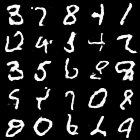

In [9]:
def lerp(a, b, t):
  x = a * (1 -t) + b * t
  return x

def animate(fm_model, points=10, samples_between=100, cols=5, rows=5):
  torch.random.manual_seed(1)
  noises = [torch.randn((cols * rows, 1, 28, 28)) for _ in range(points)]
  noises.append(noises[0])  # loop
  images = []
  for a, b in tqdm(zip(noises[:-1], noises[1:]), unit=" points"):
    for t in tqdm(range(samples_between), unit=" samples"):
      n = lerp(a, b, t / samples_between)
      images.append(sample_batch(fm_model, noise=n.to(device), num_steps=10).squeeze(1).cpu())
  i = torch.stack(images, axis=0).clip(0, 1)
  i = einops.rearrange(i, "n (gw gh) w h -> n (gw w) (gh h)", gw=cols, gh=rows)
  show_video(np.array(i[...] * 255).astype(np.uint8), fps=20, codec='gif')

animate(fm_model, points=5, samples_between=100)


## Simple Guidance (just brightness)

  0%|          | 0/30 [00:00<?, ?it/s]

""

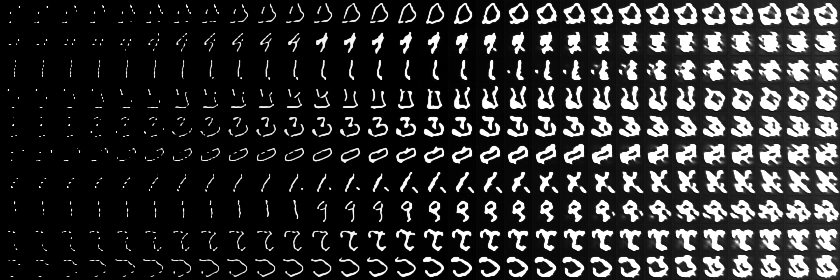

In [10]:
@torch.no_grad()
def sample_with_guidance(model, noise, guidance_fn, guidance_scale, num_steps=10):
    model.eval()
    device = next(model.parameters()).device
    x = torch.zeros_like(noise)
    for i in range(num_steps):
      t = torch.tensor([(num_steps - i) / num_steps] * x.shape[0], device=device)
      x = (1 - t[..., None, None, None]) * x + t[..., None, None, None] * noise
      x = model(x, t)

      x_for_guidance = x.detach().clone().requires_grad_(True)
      with torch.enable_grad():
        scores = guidance_fn(x_for_guidance)
        grad = torch.autograd.grad(scores, x_for_guidance)[0]

      x += guidance_scale * grad
    return x


def intensity_guidance(num_examples=10, steps=30):
  def intensity(x):
    return x.mean()

  noise = torch.randn((num_examples, 1, 28, 28), device=device)

  images = []
  for s in tqdm(range(steps), total=steps):
    scale = torch.tensor(s / (steps - 1)) * 2 - 1
    scale *= 1e3

    images.append(sample_with_guidance(fm_model, noise=noise, num_steps=100, guidance_fn=intensity, guidance_scale=scale).squeeze(1).cpu())
  i = torch.stack(images, axis=0).clip(0, 1)
  i = einops.rearrange(i, "r c w h -> (c w) (r h)")
  show_image(i)


intensity_guidance()

## Classifier Model

In [11]:
class MNISTClassifier(nn.Module):
    def __init__(self,
                 in_channels=1,         # MNIST is grayscale
                 num_classes=10,        # MNIST has 10 digits
                 base_channels=32,      # Starting number of channels
                 num_groups_norm=8,
                 use_attention_bottleneck=True):
        super().__init__()

        if base_channels <= 0:
            raise ValueError("base_channels must be positive.")

        # --- Feature Extractor using UNet Encoder/Bottleneck Structure ---
        # Time embedding components are not needed for standard classification
        # We pass time_emb_dim=None to the blocks

        # Initial convolution (maintains size: 28x28 -> 28x28)
        # Input: 1x28x28
        self.conv_in = ConvBlock(in_channels, base_channels, time_emb_dim=None, num_groups=num_groups_norm)
        # Output: C x 28 x 28

        # Encoder Path
        # Downsample 1 (28x28 -> 14x14)
        self.down1 = DownBlock(base_channels, base_channels * 2, time_emb_dim=None, num_groups_norm=num_groups_norm)
        # Output: 2C x 14 x 14
        # Downsample 2 (14x14 -> 7x7)
        self.down2 = DownBlock(base_channels * 2, base_channels * 4, time_emb_dim=None, num_groups_norm=num_groups_norm)
        # Output: 4C x 7 x 7

        # Bottleneck (operates at 7x7 resolution)
        # Increase channels
        self.bottleneck_conv1 = ConvBlock(base_channels * 4, base_channels * 8, time_emb_dim=None, num_groups=num_groups_norm)
        # Output: 8C x 7 x 7

        # Optional Self-Attention
        if use_attention_bottleneck:
            self.attention = SelfAttentionBlock(base_channels * 8, num_heads=4)
        else:
            self.attention = nn.Identity()
        # Output: 8C x 7 x 7

        # Decrease channels back (ready for potential decoder, but we stop here)
        # We will use the output of attention (or bottleneck_conv1 if no attention) for classification
        # Let's use the output AFTER attention (8C channels) for max feature richness at bottleneck
        bottleneck_out_channels = base_channels * 8

        # --- Classification Head ---
        # Global Average Pooling reduces spatial dimensions (7x7) to 1x1
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        # Output: 8C x 1 x 1

        # Final Linear layer to map features to class scores
        self.classifier_head = nn.Linear(bottleneck_out_channels, num_classes)
        # Output: num_classes

    def forward(self, x):
        # x: (batch_size, in_channels, H, W) = (B, 1, 28, 28)

        # Feature Extraction (Encoder + Bottleneck)
        # Time embedding `t_emb` is None throughout
        h = self.conv_in(x, t_emb=None)      # (B, C, 28, 28)
        h = self.down1(h, t_emb=None)        # (B, 2C, 14, 14)
        h = self.down2(h, t_emb=None)        # (B, 4C, 7, 7)
        h = self.bottleneck_conv1(h, t_emb=None) # (B, 8C, 7, 7)
        h = self.attention(h)              # (B, 8C, 7, 7)

        # Classification Head
        h = self.global_avg_pool(h)         # (B, 8C, 1, 1)
        h = torch.flatten(h, 1)             # (B, 8C)
        out_logits = self.classifier_head(h) # (B, num_classes)

        return out_logits


## CE Loss

In [12]:
def ce_loss(model, batch):
    x = batch[0]
    y = batch[1]
    # Forward pass
    y_hat = model(x)

    # Compute the loss
    loss = nn.CrossEntropyLoss()(y_hat, y)

    predicted_classes = torch.argmax(y_hat, dim=1) # Shape: [batch_size]
    accuracy = (predicted_classes == y).to(torch.float32).mean().detach().cpu()
    return dict(loss=loss, accuracy=accuracy)

## Train the classifier

In [13]:
classifier = MNISTClassifier()
classifier.to(device)


trainer = Trainer(model=classifier,
                  train_loader=train_loader,
                  test_loader=test_loader,
                  loss_fn=ce_loss,
                  extra_eval_fn=None,
                  num_epochs=1)
trainer.train()

epoch=0 test {'loss': 2.310247987508774, 'accuracy': 0.1337890625}


Epoch 1/1:   0%|          | 0/1875 [00:00<?, ? batches/s]

mean train: {'loss': {0.4100253610743274}, 'accuracy': {0.8606034482758621}}
mean train: {'loss': {0.12183365233034504}, 'accuracy': {0.964279689608637}}
epoch=0 test {'loss': 0.09496806096285582, 'accuracy': 0.96875}



## Classifier Guidance

  0%|          | 0/10 [00:00<?, ?it/s]

""

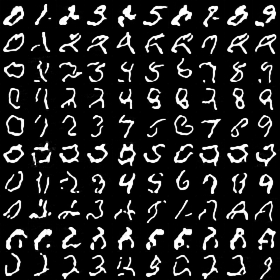

In [14]:
def class_scorer(classifier, x, class_weights):
  logits = classifier(x)
  log_probs = F.log_softmax(logits, dim=-1)
  return (log_probs * class_weights[None, :]).sum(dim=-1).mean()




def number_guidance(num_examples=10):
  noise = torch.randn((num_examples, 1, 28, 28), device=device)

  images = []
  for n in tqdm(range(10)):
    one_hot = F.one_hot(torch.tensor(n), 10).to(device)
    def scorer(x):
      return class_scorer(classifier, x, one_hot)
    images.append(sample_with_guidance(fm_model, noise=noise, num_steps=100, guidance_fn=scorer, guidance_scale=20).squeeze(1).cpu())
  i = torch.stack(images, axis=0).clip(0, 1)
  i = einops.rearrange(i, "r c w h -> (c w) (r h)")
  show_image(i)

number_guidance()